<a href="https://colab.research.google.com/github/AndreaWalrus/Esercitazione8-23-24/blob/main/QuickDrawCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercizio Quick Draw

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset, Dataset, Subset, random_split, IterableDataset, get_worker_info
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
from tqdm.auto import trange
import itertools

# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter
from tensorboard.plugins.hparams import api as hp

# This is when we use GPU instance to run colab.
# How to change Runtime in colab??
# Go to Runtime-> Change Runtime type -> Hardware Accelerator -> GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)
torch.manual_seed(42)

Using PyTorch version: 2.6.0+cu124  Device: cuda


In [3]:
import struct
import os, re, random

def unpack_drawing(fh):
    # Read one drawing record from the binary file handle
    key_id,       = struct.unpack('Q',  fh.read(8))
    country_code, = struct.unpack('2s', fh.read(2))
    recognized,   = struct.unpack('b',  fh.read(1))
    timestamp,    = struct.unpack('I',  fh.read(4))
    n_strokes,    = struct.unpack('H',  fh.read(2))

    strokes = []
    for _ in range(n_strokes):
        n_pts, = struct.unpack('H', fh.read(2))
        fmt    = f'{n_pts}B'
        x_pts  = struct.unpack(fmt, fh.read(n_pts))
        y_pts  = struct.unpack(fmt, fh.read(n_pts))
        strokes.append((x_pts, y_pts))

    return {'strokes': strokes}

def strokes_to_image(raw_strokes, size=256, line_width=1):
    """
    raw_strokes: list of strokes, each ([x0,x1,...], [y0,y1,...])
                 where each x_i, y_i is already in [0..255] integer
    size:       canvas size (should be 256)
    line_width: thickness of the drawn line (in pixels)
    """
    # White canvas
    img = Image.new("L", (size, size), color=255)
    draw = ImageDraw.Draw(img)

    # Draw each stroke without any rescaling
    for x_pts, y_pts in raw_strokes:
        # Make sure points are (x,y) tuples of ints
        points = list(zip(map(int, x_pts), map(int, y_pts)))
        if len(points) >= 2:
            draw.line(points, fill=0, width=line_width)

    # Return as NumPy array
    return np.array(img, dtype=np.uint8)

def load_quickdraw_bin(filename, n_samples=None):
    images = []
    with open(filename, 'rb') as fh:
        for i in range(n_samples):
            try:
                rec = unpack_drawing(fh)
            except struct.error:
                break
            # Render strokes in 256×256 and add to list
            img = strokes_to_image(rec['strokes'], size=256, line_width=1)
            images.append(img)
            if i%1000 == 0:
              print('Progress: '+str(int(100*i/n_samples))+'%')

    arr = np.stack(images, axis=0)
    arr = arr[:, np.newaxis, :, :].astype(np.uint8)
    return arr

def parseQuickDraw(dir, n_samples):
  imgs_array = None
  labels_array = None
  i=0
  names = []
  for f in os.listdir(dir):
    x = re.search(r"(.+)\.bin", f)
    name = str(x.group(1))
    names.append(name)
    print('Loading: '+dir+name+'.bin')

    # Load all images for each file in imgs and triplicate the channel layer
    imgs = load_quickdraw_bin(dir+name+'.bin', n_samples=n_samples)
    imgs = np.repeat(imgs, 3, axis=1)

    # Initialize the label_array and fill it up to n_samples with the file name
    labels = [name]
    labels = np.reshape(labels, (1, 1))
    labels = np.repeat(labels, n_samples, axis=0)


    if i==0:
      imgs_array = imgs
      labels_array = labels
    else:
      imgs_array = np.concatenate((imgs_array, imgs), axis=0)
      labels_array = np.concatenate((labels_array, labels), axis=0)

    i+=1
    print('Loaded: '+dir+name+'.bin\n')

    '''
    # Save both arrays as .npz for easy of access
    with open(dir+'../npy/'+name+'.npz', 'wb') as f:
      np.savez(f, label=labels, img=imgs)
      print('Saved: '+dir+'../npy/'+name+'.npz\n')
    '''
  print(imgs_array.shape)
  print(labels_array.shape)
  print('Finished')
  return imgs_array, labels_array, names

In [4]:
class QuickDrawMapDataset(Dataset):
    """
    Map-style Dataset for QuickDraw .bin files.
    Builds an index of byte offsets for each record to allow random access.

    Args:
        bin_dir (str): directory containing <class>.bin files
        classes (List[str]): list of class basenames (without .bin)
        n_per_class (int|None): max records to index per class (None for all)
        transform (callable|None): torchvision transform to apply to 3-channel tensor
    """
    def __init__(self, bin_dir, classes, n_per_class=None, transform=None):
        self.bin_dir      = bin_dir
        self.classes      = list(classes)
        self.n_per_class  = n_per_class
        self.transform    = transform
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.index        = []  # list of (class, offset)

        # Build index by scanning each file sequentially
        for cls in self.classes:
            path = os.path.join(self.bin_dir, f"{cls}.bin")
            with open(path, 'rb') as fh:
                count = 0
                while True:
                    if self.n_per_class and count >= self.n_per_class:
                        break
                    offset = fh.tell()
                    try:
                        _ = unpack_drawing(fh)
                    except Exception:
                        break
                    self.index.append((cls, offset))
                    count += 1

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        cls, offset = self.index[idx]
        path = os.path.join(self.bin_dir, f"{cls}.bin")
        with open(path, 'rb') as fh:
            fh.seek(offset)
            rec = unpack_drawing(fh)

        # Render to numpy array
        arr = strokes_to_image(rec['strokes'], size=256, line_width=1)
        # Convert to 3-channel tensor
        arr = arr[np.newaxis, :, :]
        arr = np.repeat(arr, 3, axis=0)
        img = torch.from_numpy(arr).float().div(255.0)

        if self.transform:
            img = self.transform(img)

        label = self.class_to_idx[cls]
        return img, label

    def num_classes(self):
        return len(self.classes)

In [19]:
class QuickDrawShuffledStream(IterableDataset):
    def __init__(self, bin_dir, classes, n_per_class=None, transform=None):
        """
        Streams sketches by randomly choosing among class streams.
        """
        self.bin_dir     = bin_dir
        self.classes     = list(classes)
        self.n_per_class = n_per_class
        self.transform   = transform
        self.class_to_idx= {c:i for i,c in enumerate(self.classes)}

    def __iter__(self):
        # Identify the worker that is accessing the DataSet
        worker_info = get_worker_info()
        if worker_info is None:
          worker_id = 0
          num_workers = 1
        else:
          worker_id = worker_info.id
          num_workers = worker_info.num_workers

        # Split the class list between the workers
        my_classes = [c for i, c in enumerate(self.classes) if i % num_workers == worker_id]

        # Open a file handle & counter for each class
        handles = {}
        counts  = {}
        for c in my_classes:
            path = os.path.join(self.bin_dir, f"{c}.bin")
            handles[c] = open(path, 'rb')
            counts[c]  = 0

        alive = set(my_classes)
        try:
            while alive:
                # Pick a random class that still has data
                cls = random.choice(list(alive))
                fh  = handles[cls]

                # Stop if we've hit the per‑class limit
                if self.n_per_class and counts[cls] >= self.n_per_class:
                    alive.remove(cls)
                    continue

                # Try to unpack one drawing
                try:
                    rec = unpack_drawing(fh)
                except struct.error:
                    alive.remove(cls)
                    continue

                # Render & tensorize
                arr = strokes_to_image(rec['strokes'], size=256, line_width=1)
                img = torch.from_numpy(arr).unsqueeze(0).float().div(255.0)
                img = img.repeat(3, 1, 1) # Repeat the single channel 3 times
                if self.transform:
                    img = self.transform(img)

                label = self.class_to_idx[cls]
                counts[cls] += 1
                yield img, label
        finally:
            for fh in handles.values():
                fh.close()

    def __len__(self):
        return self.n_per_class * len(self.classes)

    def num_classes(self):
        return len(self.classes)

class SliceDataset(IterableDataset):
    def __init__(self, source_ds, start, end):
        """
        source_ds: the original IterableDataset
        start:     first index to include (inclusive)
        end:       first index to *exclude* (exclusive)
        """
        self.source = source_ds
        self.start  = start
        self.end    = end

    def __iter__(self):
        # islice will skip up to start, then yield up to end
        return itertools.islice(self.source.__iter__(), self.start, self.end)

    def __len__(self):
        return self.end - self.start

In [37]:
classes = []
for f in os.listdir("datasets/QuickDraw/binary60/"):
    x = re.search(r"(.+)\.bin", f)
    name = str(x.group(1))
    classes.append(name)
print(classes)

['airplane', 'alarm clock', 'anvil', 'axe', 'banana', 'bat', 'binoculars', 'broom', 'bucket', 'cactus', 'camel', 'candle', 'cat', 'chair', 'compass', 'cow', 'dog', 'donut', 'dragon', 'elephant', 'face', 'fan', 'fire hydrant', 'giraffe', 'headphones', 'horse', 'hourglass', 'ice cream', 'key', 'knife', 'laptop', 'microphone', 'moon', 'motorbike', 'onion', 'paper clip', 'pillow', 'pizza', 'pond', 'pool', 'potato', 'scissors', 'submarine', 't-shirt', 'teddy-bear', 'tornado', 'train', 'umbrella', 'violin', 'windmill']


In [38]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

In [55]:
dataset = QuickDrawMapDataset(
    bin_dir="datasets/QuickDraw/binary60/",
    classes=classes,
    n_per_class=1200,
    transform=preprocess
)
print(len(dataset))

60000


In [56]:
n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

'''
train_ds = QuickDrawShuffledStream(bin_dir="datasets/QuickDraw/binary60/", classes=classes, n_per_class=1200, transform=preprocess)
val_ds   = QuickDrawShuffledStream(bin_dir="datasets/QuickDraw/binary60/", classes=classes, n_per_class=150, transform=preprocess)
test_ds  = QuickDrawShuffledStream(bin_dir="datasets/QuickDraw/binary60/", classes=classes, n_per_class=150, transform=preprocess)
'''
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

48000
6000
6000


In [57]:
in_feats = model.fc.in_features
model.fc = torch.nn.Linear(in_feats, dataset.num_classes())
model = model.to(device)

torch.Size([64, 3, 224, 224])
torch.Size([64])


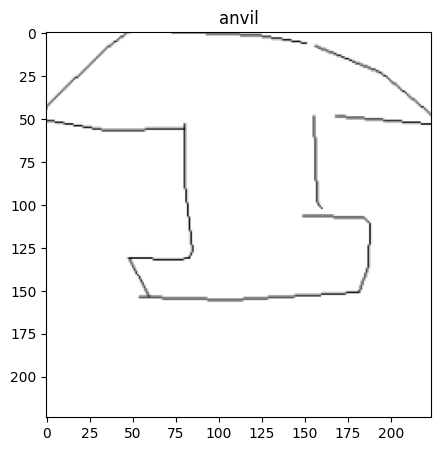

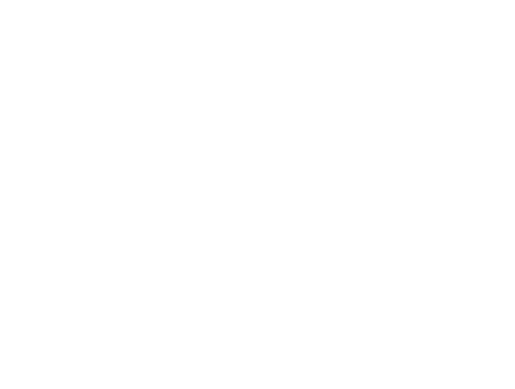

In [45]:
# Sample the dataset
imgs, labels = next(iter(train_loader))
print(imgs.shape)
print(labels.shape)

plt.figure(figsize=(5,5))
plt.title(classes[int(labels[0])])
plt.imshow(imgs[0][0], cmap="gray")
plt.show()
plt.axis('off')
plt.grid(visible=False)
plt.show()

In [58]:
num_classes = len(classes)
in_feats    = model.fc.in_features
model.fc    = nn.Linear(in_feats, num_classes).to(device)

for name, param in model.named_parameters():
    if name.startswith('fc.'):
        param.requires_grad = True
    else:
        param.requires_grad = False


In [65]:
# Reset FC layer parameters
model.fc.reset_parameters()

In [63]:
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=5e-5, weight_decay=10e-3)
criterion = nn.CrossEntropyLoss()

In [64]:
# Check if model is running on GPU
print("Using device:", device)
print("Model on:", next(model.parameters()).device)

Using device: cuda
Model on: cuda:0


In [66]:
# Training loop
%%time

epochs = 15
writer = SummaryWriter('logs/QuickDraw')
imgs = imgs.to(device)
writer.add_graph(model, imgs)
for epoch in range(1, epochs+1):

    # Train
    model.train()
    train_loss, correct = 0., 0.
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        preds = model(data)
        #preds = preds.squeeze(dim=1)

        # Calculate loss
        loss = criterion(preds, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()


        correct += (preds.argmax(1) == target).sum().item()
        train_loss+=loss.data.item()*data.size(0)

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_acc = 100*correct/len(train_loader.dataset)
    train_loss/=len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss, correct = 0, 0

    with torch.no_grad():
      for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        preds = model(data)

        val_loss += criterion(preds, target).data.item()*data.size(0)
        correct += (preds.argmax(1) == target).sum().item()

      val_acc = 100*correct/len(val_loader.dataset)
      val_loss/=len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), val_acc))

    writer.add_scalars('Loss', {'Training':train_loss, 'Validation':val_loss}, global_step=epoch)
    writer.add_scalars('Accuracy', {'Training':train_acc, 'Validation':val_acc}, global_step=epoch)
writer.close()


Train Epoch: 1 [0/48000 (0%)]	Loss: 3.897551
Train Epoch: 1 [12800/48000 (27%)]	Loss: 3.743116
Train Epoch: 1 [25600/48000 (53%)]	Loss: 3.561437
Train Epoch: 1 [38400/48000 (80%)]	Loss: 3.335281

Validation set: Average loss: 3.3255, Accuracy: 2794/6000 (47%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 3.234592
Train Epoch: 2 [12800/48000 (27%)]	Loss: 3.199215
Train Epoch: 2 [25600/48000 (53%)]	Loss: 3.093823
Train Epoch: 2 [38400/48000 (80%)]	Loss: 3.015846

Validation set: Average loss: 2.9109, Accuracy: 3227/6000 (54%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 2.976742
Train Epoch: 3 [12800/48000 (27%)]	Loss: 2.890063
Train Epoch: 3 [25600/48000 (53%)]	Loss: 2.777338
Train Epoch: 3 [38400/48000 (80%)]	Loss: 2.554238

Validation set: Average loss: 2.6458, Accuracy: 3355/6000 (56%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 2.459033
Train Epoch: 4 [12800/48000 (27%)]	Loss: 2.558879
Train Epoch: 4 [25600/48000 (53%)]	Loss: 2.426860
Train Epoch: 4 [38400/48000 (80%)]	Loss: 2.393425

Validation set: Avera

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparam)
        
        model.fc.reset_parameters()
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
    
        optimizer = optim.AdamW(model.fc.parameters(), lr=hparam[HP_LR], weight_decay=hparam[HP_WD])
        criterion = nn.CrossEntropyLoss()
    
    
        for epoch in range(2):
            model.train()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                loss = criterion(model(imgs), labels)
                loss.backward()
                optimizer.step()
    
    
        model.eval()
        correct = 0
        total   = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        acc = correct/total
        tf.summary.scalar(METRIC_ACCURACY, acc, step=1)
        return acc

In [ ]:
lrs  = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
wds  = [1e-5, 1e-4, 1e-3]
n_trials = 10

HP_LR = hp.HParam('lr', hp.RealInterval(1e-4,1e-2))
HP_WD = hp.HParam('weight_decay', hp.RealInterval(0,1e-3))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LR,HP_WD], metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')])

best_acc = 0.0
best_cfg = None
session_num = 0

for _ in trange(n_trials, desc="Random Search"):
    
    log_lr_min, log_lr_max = math.log10(1e-4), math.log10(1e-2)
    log_wd_min, log_wd_max = math.log10(1e-5), math.log10(1e-3)
    
    sampled_log_lr = random.uniform(log_lr_min, log_lr_max)
    sampled_log_wd = random.uniform(log_wd_min, log_wd_max)
    
    lr = 10**sampled_log_lr
    wd = 10**sampled_log_wd
    

    hparams = {HP_LR:lr,HP_WD:wd}
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    acc = run('logs/hparam_tuning/'+ run_name, hparams)
    session_num += 1
    
    if acc > best_acc:
        best_acc = acc
        best_cfg = {"lr": lr, "weight_decay": wd}

print(f"Best val‑acc: {best_acc*100:.2f}% with {best_cfg}")